## **Библиотеки, функции, загрузка файла**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
import matplotlib as mpl
from statsmodels.stats.proportion import proportions_ztest

Функции   

In [21]:
def rename_columns(name):
    new_name = name.replace(' ', '_').lower()
    return new_name

Загрузка файла  

In [39]:
file_id = '1ATASmLwbd-sVPOJ7kChU9fumc15lRvwK'
download_url = f'https://drive.google.com/uc?id={file_id}&export=download'
df = pd.read_csv(download_url)

df.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


# **Проверка гипотез**

В рамках блока "Проверка гипотез" первично мы хотим проверить гипотезы, что **доли покупки золотого членства различаются по разным группам наших численных переменных**. В реальной ситуации проверка данных гипотез позволила бы **фокусироваться на сегментах пользователей**, у которых стат. значимо выше доля покупок, тем самым **таргетируя предложение и снижая затраты на маркетинг**.</br>

Напомним, что наша целевая переменная - **Response (отклик на маркетинговую кампанию по продаже золотого членства, которое дает 20% скидку)**.  </br>

Проверять статистическое различие долей таргета по группам различных числовых переменных  - мы будет через **Z-test сравнения пропорций.** </br>

Постановка гипотез выглядит следующим образом (на примере - переменной Income (доход)): </br>

**H<sub>0</sub>:** Доля покупок золотого членства у группы с доходами выше 30.000 у.e. равна доле покупок золотого членства у группы с доходами равными или ниже 30.000 у.е.</br>

**H<sub>1</sub>:** Доли по группам различаются.

**Уровень статистической значимости** закладываем - **5%.**

In [43]:
#подготовка данных
df['Income'] = df['Income'].fillna(df['Income'].median())
df = df[~df['Year_Birth'].isin([1893, 1899, 1900])]
df = df[df['Income'] != 666666]
df['Total_Spending'] = (
    df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] +
    df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.difference(['Response', 'Id', 'Teenhome', 'Kidhome', 'Complain'])

print(numeric_cols)

Index(['Income', 'MntFishProducts', 'MntFruits', 'MntGoldProds',
       'MntMeatProducts', 'MntSweetProducts', 'MntWines',
       'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases',
       'NumWebPurchases', 'NumWebVisitsMonth', 'Recency', 'Total_Spending',
       'Year_Birth'],
      dtype='object')


Для проверки гипотез нам **необходимо определить, как мы будем делить выборку на две группы**, по которым будем проверять различие долей.

В данном случае мы **визуально оценим, с начала каких значений** численных переменных в их распределении **доля таргета будет увеличиваться/уменьшаться**. Для этого построим графики распределений (см. ниже).

Исходя из графиков и EDA, проделанного ранее, вырисовываются следующие группы, где доли могут разительно различаться:

| Переменная | Граница разделения| Группа с значением переменной «ниже»| Группа с значением переменной «выше» |
| ----------------------- | ----: | :-------------------- | :--------------- |
| **Income**              | 30000 | ≤ 30000               | > 30000          |
| **MntFishProducts**     |    20 | ≤ 20                  | > 20             |
| **MntFruits**           |    25 | ≤ 25                  | > 25             |
| **MntGoldProds**        |    50 | ≤ 50                  | > 50             |
| **MntMeatProducts**     |   200 | ≤ 200                 | > 200            |
| **MntSweetProducts**    |    50 | ≤ 50                  | > 50             |
| **MntWines**            |   750 | ≤ 750                 | > 750            |
| **NumCatalogPurchases** |     3 | ≤ 3                   | > 3              |
| **NumDealsPurchases**   |     3 | ≤ 3                   | > 3              |
| **NumStorePurchases**   |     5 | ≤ 5                   | > 5              |
| **NumWebPurchases**     |     5 | ≤ 5                   | > 5              |
| **NumWebVisitsMonth**   |     5 | ≤ 5                   | > 5              |
| **Recency**             |    20 | ≤ 20              | >20    |
| **Year_Birth**         |  1970 | ≤ 1970  | > 1970 |
| **Total_Spending**       |              1000 | ≤1000            | >1000            |




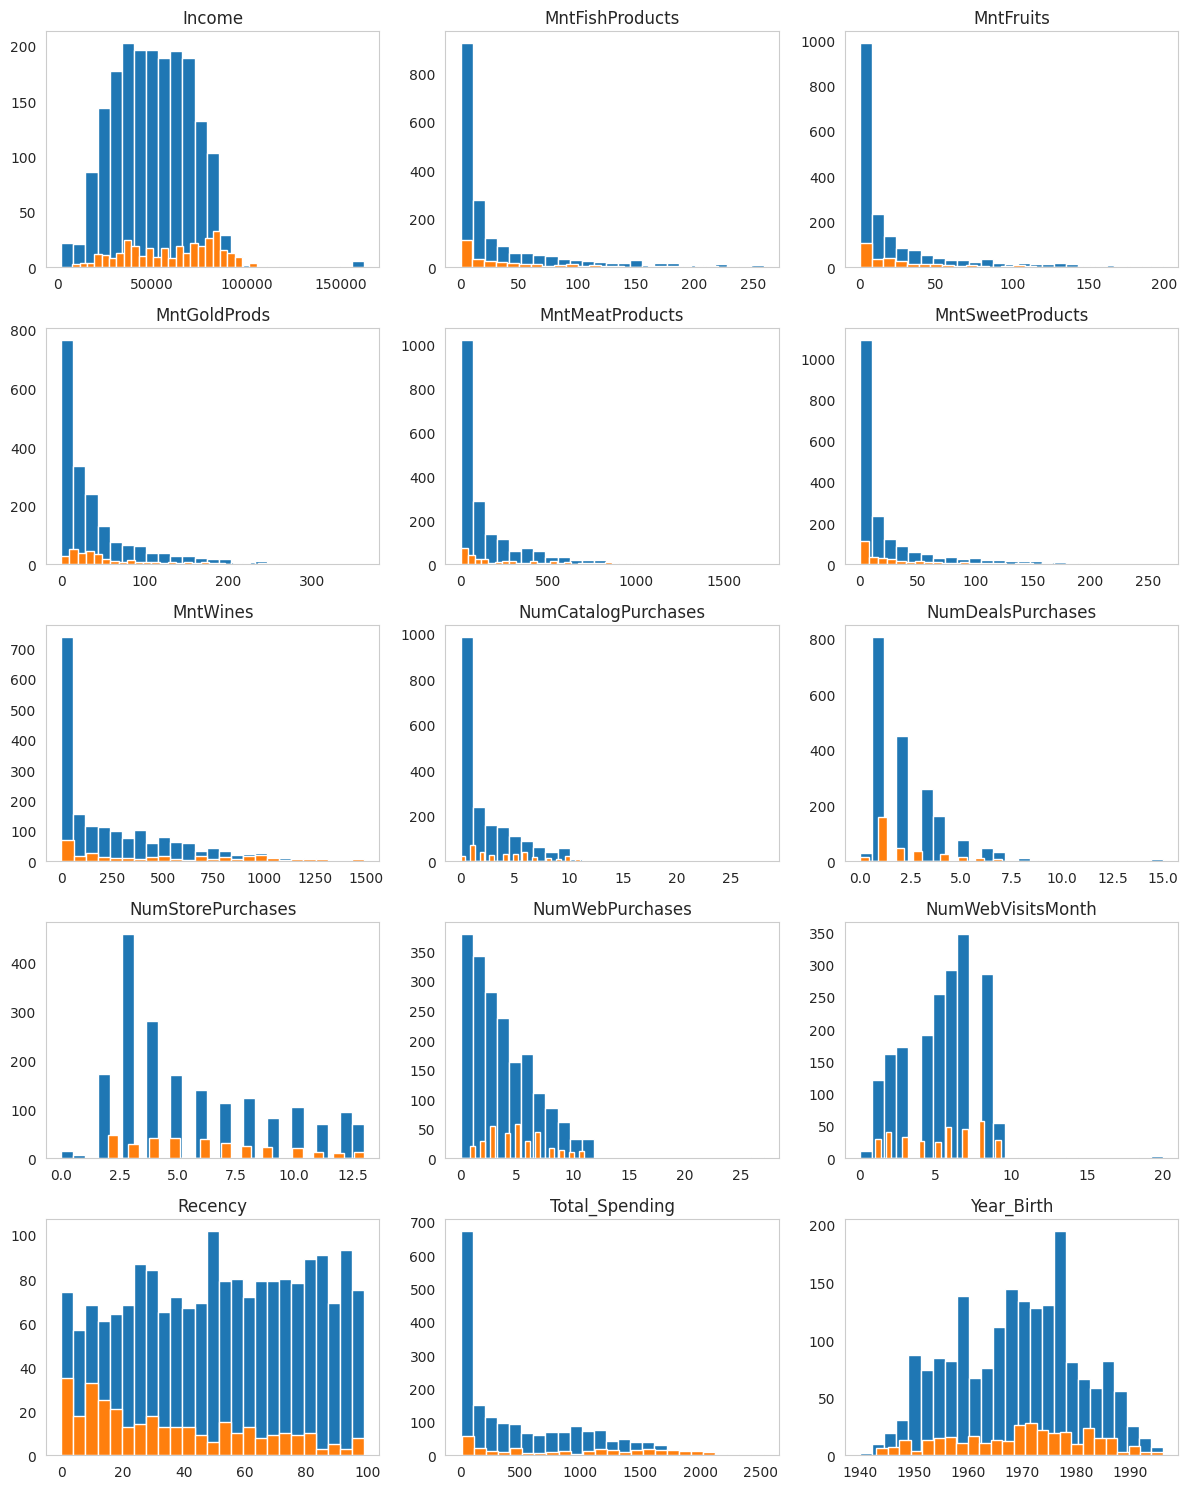

In [44]:
#визуализируем распределения числовых переменных
n = len(numeric_cols)
cols = 3
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))

for ax, var in zip(axes.flat, numeric_cols):
    ax.hist(df.loc[df.Response==0, var], bins=25,  label='Не купил')
    ax.hist(df.loc[df.Response==1, var], bins=25,  label='Купил')
    ax.set_title(var)
    ax.grid()
plt.tight_layout()
plt.show()

Гипотезы, которые мы будет проверять с помощью z-test, относятся к количественным переменным из нашего датасета:

**H<sub>1</sub>:** Доля покупок золотого членства у группы **с общими расходами выше 1000 у.e. (Total_Spending)** выше, чем у группы с общими расходами равными или ниже 1000 у.e. </br>
**Клиенты с высокими общими расходами** могут быть **более заинтересованными** принять маркетинговое предложение **с целью экономии** в конкретной сети. [Покупка программы лояльности также может увеличить траты](https://www.mckinsey.com/capabilities/growth-marketing-and-sales/our-insights/coping-with-the-big-switch-how-paid-loyalty-programs-can-help-bring-consumers-back-to-your-brand) данного клиента впоследствии на этот бренд, что применимо и к сети.
</br>
</br>

**H<sub>2</sub>:** Доля покупок золотого членства у группы **с доходами выше 30.000 у.e. (Income)** выше, чем у группы с доходами равными или ниже 30.000 у.e. </br>
**Клиенты с более высоким доходом могут чаще принимать золотое членство**, потому что для них стоимость золотого членства будет менее ощутима (500$). А для групп с меньшими доходами - это может стоить более 1% всех доходов за год, что ощутимо.
</br>
</br>

**H<sub>3</sub>:** Доля покупок золотого членства у группы клиентов, **родившихся после 1970 года (Year_Birth)**  выше, чем у группы, родившихся в 1970 году или ранее . </br>
[По опросным данным](https://www.inc.com/peter-roesler/new-study-shows-deals-promotions-affect-every-part-of-shopping-experience.html) - **миллинеалы (18-34 лет) чаще ищут промо-предложение с скидками** в Интернете перед покупкой, чем представители **старшего поколения (55+)**. Возможно, более старшие поколения их ищут в оффлайне, но различия возрастные могут быть, поэтому проверим данную гипотезу. Также метод проведения кампании может повлиять на средний возраст принятия оффера - [с возрастом люди чаще предпочитают телефонные звонки как средство коммуникации в России](https://iom.anketolog.ru/2021/08/31/pozvoni-mne).
</br>
</br>

**H<sub>4</sub>:** Доля покупок золотого членства у группы **с количеством покупок со скидками более трёх (NumDealsPurchases)** выше, чем у группы с количеством покупок со скидками равным или менее трёх . </br>
**Заинтересованные экономить на обычных скидках**, могут быть также заинтересованы сэкономить деньги за счет **скидки клубной карты** и чаще их приобретать.
</br>
</br>

**H<sub>5</sub>:** Доля покупок золотого членства у группы **с количеством посещений сайта в месяц более пяти (NumWebVisitsMonth)** ниже, чем у группы с количеством посещений сайта в месяц  равным или менее пяти раз. </br>
[Более активными интернет-пользователями являются более молодые поколения](https://www.levada.ru/2024/04/23/auditoriya-polzovatelej-interneta-sotsialnyh-setej-messendzherov-i-vpn-servisov/), а они в свою очередь [не предпочитают коммуникацию через телефонный звонок](https://iom.anketolog.ru/2021/08/31/pozvoni-mne). Это могло повлиять на предложение им клубной карты.
</br>
</br>

**H<sub>6</sub>:** Доля покупок золотого членства у группы **с количеством покупок в оффлайн-магазине более пяти (NumStorePurchases)** выше, чем у группы с количеством покупок в оффлайн-магазине равным или меньшим пяти. </br>
Клиенты с более высокой покупательской активностью могут чаще задумываться **о большей выгоде при приобретении золотого членства**, дающего скидку в 20%. Это может склонять их к его покупке.
</br>
</br>

**H<sub>7</sub>:** Доля покупок золотого членства у группы **с количеством покупок через каталог более трех (NumCatalogPurchases)** выше, чем у группы с количеством покупок через каталог равным или меньшим трех. </br>
В данном случае предпоссылка такая же, как и в гипотезе №6.
</br>
</br>


**H<sub>8</sub>:** Доля покупок золотого членства у группы **с количеством покупок в онлайн-магазине более пяти(NumWebPurchases)** выше, чем у группы с количеством покупок через каталог равным или меньшим пяти. </br>
В данном случае предпоссылка такая же, как и в гипотезе №6.
</br>
</br>


**H<sub>9</sub>:** Доля покупок золотого членства у группы, **cовершавшей последние покупки более 20 дней назад(NumWebPurchases)**, ниже, чем у группы, совершавшей последние покупки 20 дней назад или менее. </br>
Клиенты, совершавшие **покупки недавно, чаще соглашаются**, в то время, как **давние клиенты могли потерять лояльность к сети** и быть незаинтересованными в предложении.
</br>
</br>

**H<sub>10,11,12,13,14,15</sub>:** Доля покупок золотого членства у группы **с расходами по различным категориям выше определенных визуальных трешхолдов (MntWines, MntFishProducts, MntFruits, MntGoldProds, MntSweetProducts, MntMeatProducts)** выше, чем у группы с расходами по различным категориям ниже или равным трешхолдам. </br>
В целом **чем выше траты, чем большее желание у клиентов может быть экономить** на них и тем более вероятно они купят золотое членство. Но скорее всего **эффект этого может быть виден с категориями с высоким чеком** - Вино(MntWines) или Золотые изделия (MntGoldProds).

</br>

In [45]:
from statsmodels.stats.proportion import proportions_ztest

thresholds = {'Income':30000,
              'MntFishProducts':20,
              'MntFruits':25,
              'MntGoldProds':50,
              'MntMeatProducts':200,
              'MntSweetProducts':50,
              'MntWines':  750,
              'NumCatalogPurchases':3,
              'NumDealsPurchases':3,
              'NumStorePurchases':5,
              'NumWebPurchases':5,
              'NumWebVisitsMonth':5,
              'Recency':20,
              'Year_Birth':1970,
              'Total_Spending':1000}

results = []

for variable, threshold  in thresholds.items():
  lower  = df[variable] <= threshold #границу включаем в группу, с более меньшим значением признака
  higher = df[variable] >  threshold
  count_lower= lower.sum()
  count_higher= higher.sum()
  responced_count_lower = df.loc[lower,  'Response'].sum()
  responced_count_higher = df.loc[higher,  'Response'].sum()
  proportion_lower = responced_count_lower/count_lower
  proportion_higher = responced_count_higher/count_higher
  z_stat, p_value = proportions_ztest([responced_count_lower, responced_count_higher], [count_lower, count_higher])
  results.append({
        'Переменная':variable,
        'Граница разделения': threshold,
        'Кол-во наблюдений в группе "ниже"':count_lower,
        'Доля купивших в группе "ниже"':proportion_lower,
        'Кол-во наблюдений в группе "выше"':count_higher,
        'Доля купивших в группе "выше"':proportion_higher,
        'z-statistics':z_stat,
        'p-value':p_value,
        'p > 0.05':p_value < 0.05})

pd.DataFrame(results).sort_values('p-value')


,Переменная,Граница разделения,"Кол-во наблюдений в группе ""ниже""","Доля купивших в группе ""ниже""","Кол-во наблюдений в группе ""выше""","Доля купивших в группе ""выше""",z-statistics,p-value,p > 0.05
6,MntWines,750,1955,0.117136,281,0.373665,-11.280335,1.641200e-29,True
14,Total_Spending,1000,1635,0.099694,601,0.284526,-10.870005,1.601918e-27,True
12,Recency,20,477,0.285115,1759,0.112564,9.377085,6.782153e-21,True
4,MntMeatProducts,200,1608,0.105721,628,0.261146,-9.266195,1.929055e-20,True
7,NumCatalogPurchases,3,1540,0.102597,696,0.252874,-9.230229,2.700537e-20,True
2,MntFruits,25,1574,0.121347,662,0.216012,-5.732963,9.869135e-09,True
1,MntFishProducts,20,1359,0.114790,877,0.202965,-5.710962,1.123393e-08,True
5,MntSweetProducts,50,1839,0.130506,397,0.236776,-5.387095,7.160549e-08,True
10,NumWebPurchases,5,1608,0.128109,628,0.203822,-4.513840,6.366432e-06,True
3,MntGoldProds,50,1618,0.128554,618,0.203883,-4.468968,7.859772e-06,True


### Выводы по гипотезам о неравенстве долей таргета по различным группам:
* **H<sub>1</sub> не отвергается - Доля покупок золотого членства у группы **с общими расходами выше 1000 у.e. (Total_Spending)** выше, чем у группы с общими расходами равными или ниже 1000 у.e. </br> Такие же результаты и с гипотезами по переменными расходов по категориям H<sub>10,11,12,13,14,15</sub> - доли покупок золотого членства статистически значимо выше у групп с более высокими тратами.
* **Гипотеза H<sub>2</sub> не отвергается**. Доля покупок золотого членства у группы **с доходами выше 30.000 у.e. (Income)** выше, чем у группы с доходами равными или ниже 30.000 у.e.
* **Гипотезы H<sub>6</sub>, H<sub>7</sub> и H<sub>8</sub> не отвергаются.** **Клиенты с более высокой покупательской активностью чаще покупают золотое членство**, причем это наблюдается и при покупках с помощью каталога и в оффлайн и онлайн-магазинах.
* **Гипотеза H<sub>9</sub> не отвергается. Клиенты, совершавшие покупки недавно, чаще соглашаются.** Возможно, это связано с нашей предпоссылкой о лояльности клиента.
* **Доли покупок золотого членства статистически значимо не различаются только по трём переменным - Year_Birth(H<sub>3</sub>), NumWebVisitsMonth (H<sub>5</sub>) и NumDealsPurchases (H<sub>4</sub>).**
  - Для **Year_Birth(H<sub>3</sub>) и NumWebVisitsMonth (H<sub>5</sub>)** - основной предпоссылкой служило различие молодого и старшего поколения. В данном случае визуально и при сравнении долей - доля выше, но это не стат.значимое различие.
  - Для **NumDealsPurchases (H<sub>4</sub>)** - хоть визуально и при сравнении долей - доля выше, но это не стат.значимо. Основной предпоссылкой являлось желание сэкономить, но возможно, данная группа пользователей и так экономит на обычных скидках, выбирая только данные товары, и они не готовы тратить 500 долларов на клубную карту для скидки на обычные товары.

## Гипотеза 16 – «Семьи с детьми больше тратят на сладости и  и чаще совершают покупки по скидкам»

**Формулировка**  
Семьи, где есть хотя бы один ребёнок (`Kidhome + Teenhome > 0`), тратят больше на сладости (`MntSweetProducts`) и чаще совершают покупки по скидкам (`NumDealsPurchases`), чем семьи без детей.

**Обоснование**  
Дети повышают спрос на сладкое и заставляют родителей искать акции — типичный паттерн FMCG-рынка.

**Бизнес-смысл:**  
Проверяется является ли семейный сегмент целевым для промо сладостей и скидок. Повышает точность маркетинговых кампаний и кросс-продажи.

**H0 (нулевая гипотеза):**  
Средние значения `MntSweetProducts` и `NumDealsPurchases` не различаются между семьями с детьми и без.

**H1 (альтернативная гипотеза):**  
Семьи с детьми тратят больше на сладости и чаще совершают покупки со скидкой.

**Переменные:**  
- `Kidhome`, `Teenhome` → формируют бинарный признак `HasKids`  
- `MntSweetProducts`, `NumDealsPurchases`

**Тест / метод:**  
- Манн–Уитни или t-тест (в зависимости от нормальности)
- Bootstrap 95% CI разницы медиан для `MntSweetProducts`

In [28]:
from scipy.stats import mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Создание переменной "есть дети"
df["HasKids"] = (df["Kidhome"] + df["Teenhome"] > 0).astype(int)

# Группы
kids = df[df["HasKids"] == 1]
no_kids = df[df["HasKids"] == 0]

Тест: сладости

<Axes: xlabel='MntSweetProducts', ylabel='Count'>

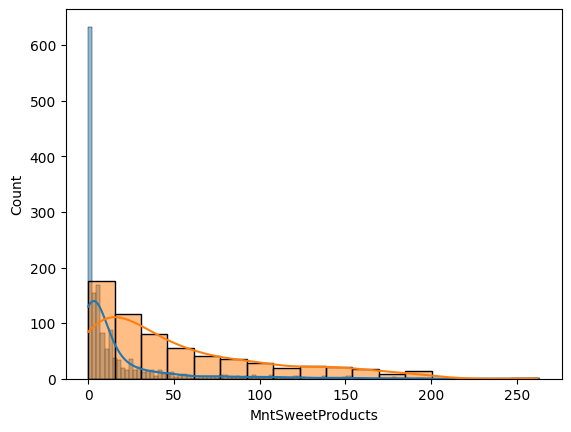

In [29]:
# Проверка нормальности (необязательно)
sns.histplot(kids['MntSweetProducts'], kde=True)
sns.histplot(no_kids['MntSweetProducts'], kde=True)

Распределение переменной MntSweetProducts на гистограммах выглядит сильно скошенным вправо. Много клиентов с малыми затратами, и очень мало — с большими.
Поэтому используем непараметрический тест Манна–Уитни, и Bootstrap-медиан и доверительных интервалов.

In [30]:
# Манн–Уитни
stat1, pval1 = mannwhitneyu(kids["MntSweetProducts"], no_kids["MntSweetProducts"], alternative='greater')

# Bootstrap 95% CI
boot_diffs = []
for _ in range(10000):
    sample1 = resample(kids["MntSweetProducts"], replace=True)
    sample2 = resample(no_kids["MntSweetProducts"], replace=True)
    boot_diffs.append(sample1.median() - sample2.median())

ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5])

Тест: покупки со скидкой

In [31]:
stat2, pval2 = mannwhitneyu(kids["NumDealsPurchases"], no_kids["NumDealsPurchases"], alternative='greater')

Результаты проверки гипотезы

Результаты проверки гипотезы:
MntSweetProducts:
 - Статистика: 233167.50
 - P-value: 1.0000
95% CI разницы медиан: [-36.00; -26.00]

NumDealsPurchases:
 - Статистика: 844328.50
 - P-value: 0.0000


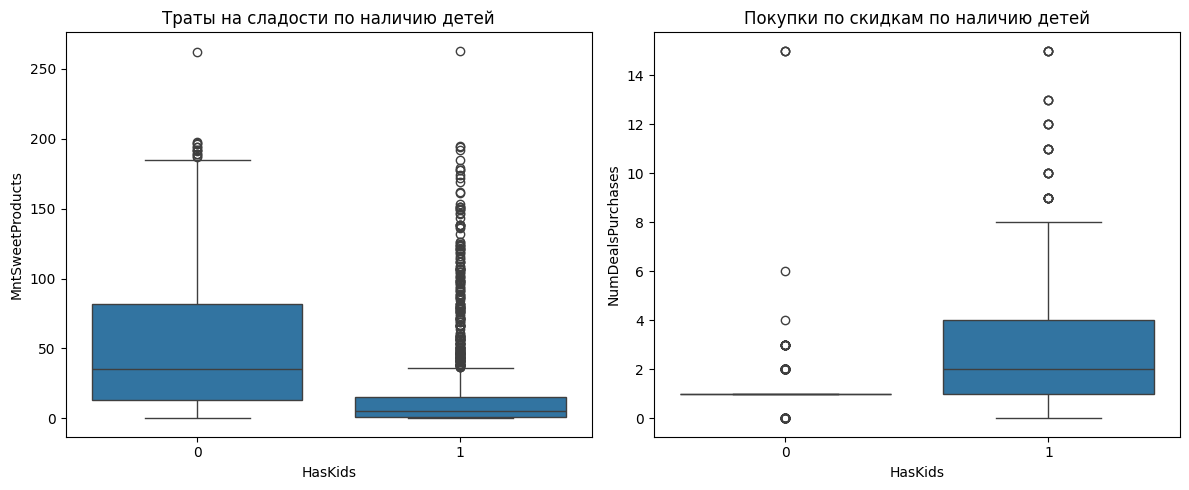

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df, x="HasKids", y="MntSweetProducts", ax=axs[0])
axs[0].set_title("Траты на сладости по наличию детей")

sns.boxplot(data=df, x="HasKids", y="NumDealsPurchases", ax=axs[1])
axs[1].set_title("Покупки по скидкам по наличию детей")
plt.tight_layout()

print(f"Результаты проверки гипотезы:")
print(f"MntSweetProducts:\n - Статистика: {stat1:.2f}\n - P-value: {pval1:.4f}")
print(f"95% CI разницы медиан: [{ci_low:.2f}; {ci_high:.2f}]")

print(f"\nNumDealsPurchases:\n - Статистика: {stat2:.2f}\n - P-value: {pval2:.4f}")

Выводы
1. MntSweetProducts:
* нет статистически значимых различий в тратах на сладости между семьями с детьми и без. Более того, медианная разница отрицательная — семьи с детьми тратят меньше. Нулевая гипотеза не отвергнута.
* Boxplot по MntSweetProducts показывает, что бездетные клиенты в среднем тратят больше на сладости.

2. NumDealsPurchases:
* статистически значимое различие есть — семьи с детьми чаще совершают покупки по скидкам. Нулевая гипотеза отвергнута.
* Boxplot по NumDealsPurchases — семьи с детьми явно активнее покупают по скидкам.

Семейные клиенты чувствительны к скидкам. Продуктовые предложения для них стоит адаптировать не по объёму (как ожидалось), а по выгоде, упаковке и частоте промо.

## Гипотеза 17 – «Стаж клиента влияет на отклик»

**Формулировка:**  
«Старые» клиенты (стаж > 12 месяцев, `Dt_Customer`) чаще откликаются на кампанию (`Response = 1`), чем «новые» (стаж ≤ 12 месяцев).

**Обоснование:**  
Предполагалось, что новые клиенты проявляют больше интереса на этапе онбординга. Однако возможно, что именно «старые» клиенты — более лояльные и склонны чаще откликаться на предложения. Гипотеза направлена на проверку этой альтернативной гипотезы.

**Бизнес-смысл:**  
Подтверждение гипотезы оправдывает фокус на удержании и стимулировании повторных покупок у лояльных клиентов, а не на избыточных вложениях в онбординг. Это позволит:
- сократить маркетинговые расходы на новые сегменты;
- усилить программы лояльности для старых клиентов;
- повысить ROI за счёт более эффективного таргетинга.

**H0 (нулевая гипотеза):**  
Доли отклика (`Response = 1`) у новых (≤ 12 месяцев) и старых (> 12 месяцев) клиентов одинаковы.

**H1 (альтернативная гипотеза):**  
Доля отклика у «старых» клиентов выше, чем у «новых».

**Переменные:**  
- `Dt_Customer` — дата регистрации клиента;  
- `StajFlag` — бинарная переменная (1 = новый, 0 = старый);  
- `Response` — отклик на кампанию (1 = отклик, 0 = нет).

**Тест / метод:**  
- Хи-квадрат тест независимости по таблице сопряженности `StajFlag × Response`, α = 0.05.  
- Логистическая регрессия: `Response ~ StajFlag` (опционально, для подтверждения направления и силы эффекта).


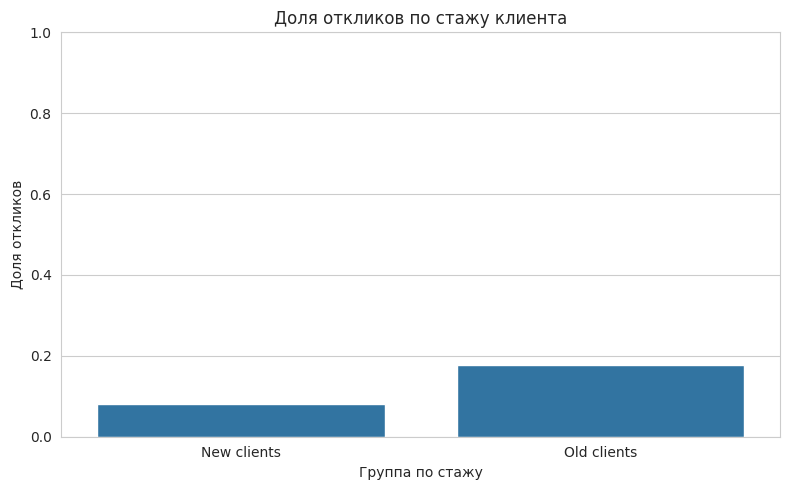

Результаты теста:
Chi2 = 31.05
P-value = 0.0000


In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Преобразуем дату клиента в формат datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

# Определяем максимальную дату в данных
reference_date = df['Dt_Customer'].max()

# Создаём переменную "стаж клиента": 1 — новый клиент (за последние 12 мес), 0 — старый
df['StajFlag'] = (df['Dt_Customer'] >= (reference_date - pd.DateOffset(months=12))).astype(int)

# Добавляем читаемую группу
df['StajGroup'] = df['StajFlag'].map({1: 'New clients', 0: 'Old clients'})

# Преобразуем Response в числовой формат (если нужно)
if df['Response'].dtype == object:
    df['Response_numeric'] = df['Response'].map({'Купил': 1, 'Не купил': 0})
else:
    df['Response_numeric'] = df['Response']

# Фильтруем данные, удаляя пропуски
df_filtered = df[['StajFlag', 'StajGroup', 'Response_numeric']].dropna()

# Проверим, что переменные есть и заполнены
if df_filtered.empty:
    raise ValueError("После фильтрации нет данных для анализа.")

# Доля откликов
response_rates = df_filtered.groupby('StajGroup')['Response_numeric'].mean().reset_index()

# Построим график
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(x='StajGroup', y='Response_numeric', data=response_rates)
plt.title('Доля откликов по стажу клиента')
plt.ylabel('Доля откликов')
plt.xlabel('Группа по стажу')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Хи-квадрат тест
contingency = pd.crosstab(df_filtered['StajFlag'], df_filtered['Response_numeric'])
chi2, p_value, dof, expected = chi2_contingency(contingency)

# Вывод результатов
print("Результаты теста:")
print(f"Chi2 = {chi2:.2f}")
print(f"P-value = {p_value:.4f}")


**Вывод:**  

Нулевая гипотеза отвергнута: доли откликов у новых (стаж ≤ 12 месяцев) и старых (стаж > 12 месяцев) клиентов **статистически значимо различаются**. Но в отличие от исходного предположения, **старые клиенты** откликнулись на кампанию **чаще**, чем новые. Возможные причины: отсутствие устойчивого интереса к продукту, слабая вовлечённость или ограниченный контакт с брендом на момент кампании.

**Рекомендации:**
- **Оптимизировать стратегию онбординга:** добавить дополнительные коммуникации или триггеры (e-mail, push, скидки) для новых клиентов в первые месяцы после регистрации.
- **Укреплять программы лояльности:** концентрировать усилия на поддержке заинтересованности клиентов со стажем > 12 месяцев.
- **Использовать стаж в сегментации:** использовать `StajFlag` при формировании целевых аудиторий для будущих кампаний.

## Гипотеза 18 – «Наличие детей снижает вероятность отклика на маркетинговую кампанию»

**Формулировка**

Клиенты, у которых есть дети (Kidhome > 0 или Teenhome > 0), реже откликаются на маркетинговую кампанию (Response = 1), по сравнению с клиентами без детей.

**Обоснование**:

Семьи с детьми обладают иным поведенческим профилем: бюджетные ограничения, ограниченное внимание к нецелевым кампаниям и приоритеты, отличающиеся от бездетных клиентов. Если предложения не адаптированы под семейные нужды, отклик может быть ниже.

**Бизнес-смысл:**
Если гипотеза подтвердится, маркетинговым командам следует разрабатывать отдельные кампании для клиентов с детьми, учитывающие их нужды и контекст. Это повысит релевантность коммуникаций и улучшит общую эффективность кампаний. Пренебрежение сегментированием может вести к потере потенциальной прибыли и лояльности.

**H0 (нулевая гипотеза):**
Вероятность отклика (Response = 1) одинакова у клиентов с детьми и без.

**H1 (альтернативная гипотеза):**
Клиенты с детьми реже откликаются на кампанию по сравнению с клиентами без детей.

**Переменные:**

Kidhome — количество маленьких детей

Teenhome — количество подростков

HasChildren — бинарная переменная (1 = есть дети, 0 = нет)

Response — бинарная переменная: отклик на кампанию

**Метод:**

Тест: Хи-квадрат тест независимости (HasChildren × Response), уровень значимости α = 0.05; логистическая регрессия Response ~ HasChildren



<ipython-input-34-1310775496>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='HasChildren', y='mean', data=response_rates, palette='Set2', capsize=0.2)


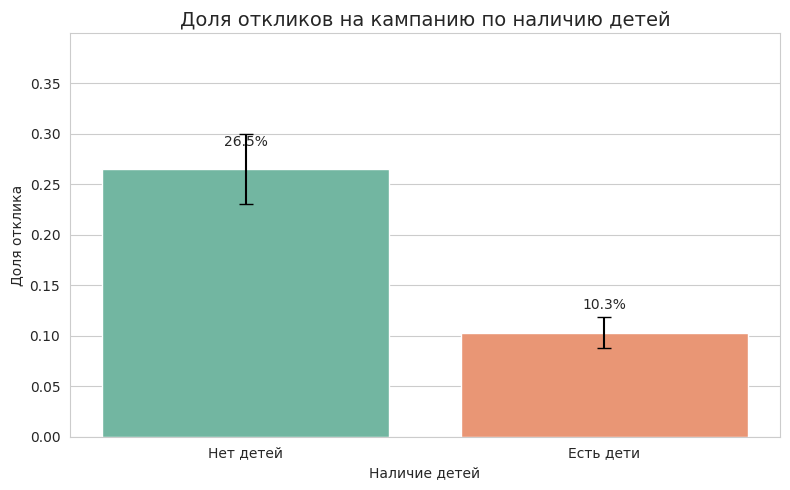


Таблица сопряженности (абсолютные значения):


Response_numeric,0,1,All
HasChildren,,,
0,468,169,637
1,1434,165,1599
All,1902,334,2236



Таблица сопряженности (в процентах):


Response_numeric,0,1
HasChildren,,
0,73.47,26.53
1,89.68,10.32



Хи-квадрат тест
  Статистика Хи-квадрат: 92.952
  p-значение: 0.0
  V Крамера (размер эффекта): 0.144
  Мин. ожидаемая частота: 95.15
  Вывод: Значимое отличие

Логистическая регрессия
  Отношение шансов (OR): 0.319
  95% ДИ OR: (0.251, 0.404)
  p-значение: 0.0
  Вывод: Наличие детей статистически снижает вероятность отклика


In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
from IPython.display import display

# Если уже было числовое преобразование, просто копируем
df['Response_numeric'] = df['Response'] if set(df['Response'].unique()) <= {0, 1} else df['Response'].map({'Купил': 1, 'Не купил': 0})

# Создание бинарной переменной "Есть дети"
df['HasChildren'] = ((df['Kidhome'] > 0) | (df['Teenhome'] > 0)).astype(int)

# Проверка и очистка данных
df_model = df[['Response_numeric', 'HasChildren']].dropna()

# Проверка на наличие данных
if df_model.empty:
    raise ValueError("Нет данных для анализа после удаления пропусков.")

# Хи-квадрат тест: таблица сопряженности
contingency = pd.crosstab(df_model['HasChildren'], df_model['Response_numeric'], margins=True)
contingency_pct = pd.crosstab(df_model['HasChildren'], df_model['Response_numeric'], normalize='index') * 100

chi2, p_value, dof, expected = chi2_contingency(contingency.iloc[:-1, :-1])
n = contingency.iloc[:-1, :-1].to_numpy().sum()
phi2 = chi2 / n
r, k = contingency.shape[0] - 1, contingency.shape[1] - 1
cramers_v = np.sqrt(phi2 / min(r, k))

# Логистическая регрессия
logit_model = smf.logit('Response_numeric ~ HasChildren', data=df_model).fit(disp=0)
odds_ratio = np.exp(logit_model.params['HasChildren'])
conf = logit_model.conf_int().loc['HasChildren']
conf_odds = np.exp(conf)

# Подготовка данных для визуализации
response_rates = df_model.groupby('HasChildren')['Response_numeric'].agg(['mean', 'count']).reset_index()
response_rates['HasChildren'] = response_rates['HasChildren'].map({0: 'Нет детей', 1: 'Есть дети'})
response_rates['se'] = np.sqrt(response_rates['mean'] * (1 - response_rates['mean']) / response_rates['count'])
response_rates['ci_lower'] = response_rates['mean'] - 1.96 * response_rates['se']
response_rates['ci_upper'] = response_rates['mean'] + 1.96 * response_rates['se']

# Визуализация: столбчатая диаграмма с доверительными интервалами
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
ax = sns.barplot(x='HasChildren', y='mean', data=response_rates, palette='Set2', capsize=0.2)
for i, row in response_rates.iterrows():
    ax.text(i, row['mean'] + 0.02, f'{row["mean"]:.1%}', ha='center', va='bottom')
plt.errorbar(x=response_rates.index, y=response_rates['mean'],
             yerr=1.96 * response_rates['se'], fmt='none', c='black', capsize=5)
plt.title('Доля откликов на кампанию по наличию детей', fontsize=14)
plt.ylabel('Доля отклика')
plt.xlabel('Наличие детей')
plt.ylim(0, max(response_rates['ci_upper']) + 0.1)
plt.tight_layout()
plt.show()

# Интерпретация результатов
summary = {
    "Хи-квадрат тест": {
        "Статистика Хи-квадрат": round(chi2, 3),
        "p-значение": round(p_value, 4),
        "V Крамера (размер эффекта)": round(cramers_v, 3),
        "Мин. ожидаемая частота": round(expected.min(), 2),
        "Вывод": "Значимое отличие" if p_value < 0.05 else "Отличий не обнаружено"
    },
    "Логистическая регрессия": {
        "Отношение шансов (OR)": round(odds_ratio, 3),
        "95% ДИ OR": tuple(np.round(conf_odds, 3)),
        "p-значение": round(logit_model.pvalues['HasChildren'], 4),
        "Вывод": (
            "Наличие детей статистически снижает вероятность отклика"
            if logit_model.pvalues['HasChildren'] < 0.05 and odds_ratio < 1
            else "Эффект отсутствует или положительный"
        )
    }
}

def print_summary(summary_dict):
    for block, content in summary_dict.items():
        print(f"\n{block}")
        for key, value in content.items():
            print(f"  {key}: {value}")

# Вывод таблиц и интерпретации
print("\nТаблица сопряженности (абсолютные значения):")
display(contingency)

print("\nТаблица сопряженности (в процентах):")
display(contingency_pct.round(2))

print_summary(summary)


Вывод

- **Результаты chi2-теста:**
  - chi2 = 92.952, p-value < 0.0001
  - Минимальное ожидаемое значение в таблице: 95.13 (допущения соблюдены)
  - **Вывод:** Нулевая гипотеза отвергается. Имеется статистически значимая разница в откликах между клиентами с детьми и без.

- **Результаты логистической регрессии:**
  - Отношение шансов (odds ratio) = **0.319**, 95% CI: [0.251, 0.404], p-value < 0.0001
  - Наличие детей **снижает вероятность отклика более чем в 3 раза**. Эффект статистически значим.

- Клиенты **без детей откликаются чаще**: ~26.5% против ~10.3%.
- Наличие детей оказывает **отрицательное влияние на отклик**.
- Эффект подтверждён **двумя независимыми методами**: хи-квадрат и логистической регрессией.

Рекомендации

1. **Сегментировать аудиторию по наличию детей** (переменная `HasChildren`) для повышения точности таргетинга.
2. **Разработать отдельные кампании и предложения для семей с детьми**, учитывая их особые потребности (товары для детей, семейные наборы, гибкие форматы коммуникаций).
3. **Исключить клиентов с детьми из массовых кампаний**, нацеленных на индивидуальных потребителей, чтобы не снижать общий отклик.
4. **Использовать переменную `HasChildren` как фичу в модели предсказания отклика** (feature engineering).


## Гипотеза 19 – «Мультиканальные клиенты более склонны откликаться на кампанию»

**Формулировка**

Клиенты, которые совершают покупки через все три канала — магазин (`NumStorePurchases`), веб-сайт (`NumWebPurchases`) и каталог (`NumCatalogPurchases`) — имеют более высокую вероятность отклика (Response = 1), чем остальные клиенты.

**Обоснование**

Активность во всех каналах продаж — признак высокой вовлечённости, лояльности и доверия к бренду. Такие клиенты более открыты коммуникациям и с большей вероятностью примут участие в маркетинговых инициативах.

**Бизнес-смысл**

Подтверждение гипотезы позволит:
- Сегментировать "тёплую" аудиторию — мультиканальных клиентов.
- Нацелить на них персонализированные или премиальные предложения.
- Повысить отклик и рентабельность кампаний за счёт фокусировки на лояльной группе.

**H₀ (нулевая гипотеза)**

Вероятность отклика (Response = 1) **не зависит** от того, активен ли клиент во всех трёх каналах.

**H₁ (альтернативная гипотеза)**

Клиенты, использующие **все три канала**, откликаются **чаще**, чем остальные.

**Переменные**

- **NumWebPurchases** — количество покупок через сайт.
- **NumCatalogPurchases** — количество покупок по каталогу.
- **NumStorePurchases** — количество покупок в магазине.
- **ChannelCount** — количество каналов с активностью (>0).
- **IsMultichannel** — бинарная переменная: 1, если ChannelCount == 3, иначе 0.
- **Response** — целевая переменная: 1 — отклик, 0 — нет.

**Тест**

- Хи-квадрат тест независимости (IsMultichannel × Response).
- логистическая регрессия `Response ~ IsMultichannel`.

<ipython-input-35-3057118472>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='IsMultichannel', y='mean', data=response_rate, capsize=0.1, palette='Set1')


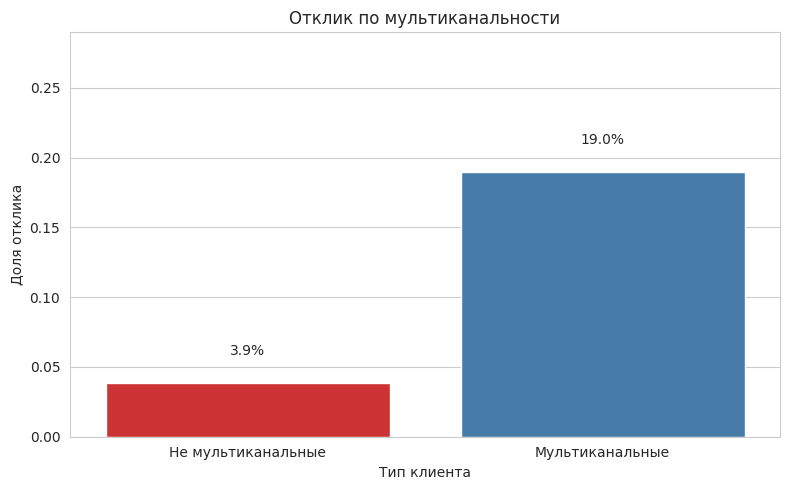

Таблица сопряжённости (counts):


Response_numeric,0,1,All
IsMultichannel,,,
0,574,23,597
1,1328,311,1639
All,1902,334,2236


Таблица сопряжённости (проценты):


Response_numeric,0,1
IsMultichannel,,
0,96.15,3.85
1,81.03,18.97



Хи-квадрат тест:
Хи-квадрат = 77.575, p-value = 0.0000, Cramer's V = 0.132
Вывод: Нулевая гипотеза отвергнута.

Логистическая регрессия:
Odds Ratio = 5.844, 95% CI = (3.784, 9.027), p-value = 0.0000
Вывод: Мультиканальные клиенты статистически значимо чаще откликаются.


In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
from IPython.display import display

# Преобразование Response в числовую переменную
if df['Response'].dtype == object:
    df['Response_numeric'] = df['Response'].map({'Купил': 1, 'Не купил': 0})
else:
    df['Response_numeric'] = df['Response']  # Уже числовая

# Создание переменной ChannelCount
df['ChannelCount'] = (
    (df['NumWebPurchases'] > 0).astype(int) +
    (df['NumCatalogPurchases'] > 0).astype(int) +
    (df['NumStorePurchases'] > 0).astype(int)
)

# Бинарная переменная: мультиканальный клиент
df['IsMultichannel'] = (df['ChannelCount'] == 3).astype(int)

# Удаление пропусков перед анализом
df_model = df[['Response_numeric', 'IsMultichannel']].dropna()
if df_model.empty:
    raise ValueError("Нет данных для анализа после удаления пропусков.")

#  Хи-квадрат тест
contingency = pd.crosstab(df_model['IsMultichannel'], df_model['Response_numeric'], margins=True)
contingency_pct = pd.crosstab(df_model['IsMultichannel'], df_model['Response_numeric'], normalize='index') * 100

chi2, p_value, dof, expected = chi2_contingency(contingency.iloc[:-1, :-1])
min_expected = expected.min()
n = contingency.iloc[:-1, :-1].to_numpy().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))

#Логистическая регрессия
model = smf.logit("Response_numeric ~ IsMultichannel", data=df_model).fit(disp=0)
odds_ratio = np.exp(model.params['IsMultichannel'])
ci = model.conf_int().loc['IsMultichannel']
odds_ci = np.exp(ci)

# Визуализация
response_rate = df_model.groupby('IsMultichannel')['Response_numeric'].agg(['mean', 'count']).reset_index()
response_rate['IsMultichannel'] = response_rate['IsMultichannel'].map({0: 'Не мультиканальные', 1: 'Мультиканальные'})
response_rate['se'] = np.sqrt(response_rate['mean'] * (1 - response_rate['mean']) / response_rate['count'])

plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
ax = sns.barplot(x='IsMultichannel', y='mean', data=response_rate, capsize=0.1, palette='Set1')
for i, row in response_rate.iterrows():
    ax.text(i, row['mean'] + 0.02, f"{row['mean']:.1%}", ha='center')
plt.ylabel("Доля отклика")
plt.xlabel("Тип клиента")
plt.title("Отклик по мультиканальности")
plt.ylim(0, max(response_rate['mean'] + 0.1))
plt.tight_layout()
plt.show()


print("Таблица сопряжённости (counts):")
display(contingency)

print("Таблица сопряжённости (проценты):")
display(contingency_pct.round(2))

print("\nХи-квадрат тест:")
print(f"Хи-квадрат = {chi2:.3f}, p-value = {p_value:.4f}, Cramer's V = {cramers_v:.3f}")
print("Вывод:", "Нулевая гипотеза отвергнута." if p_value < 0.05 else "Нулевая гипотеза не отвергнута.")

print("\nЛогистическая регрессия:")
print(f"Odds Ratio = {odds_ratio:.3f}, 95% CI = ({odds_ci[0]:.3f}, {odds_ci[1]:.3f}), p-value = {model.pvalues['IsMultichannel']:.4f}")
print("Вывод:", "Мультиканальные клиенты статистически значимо чаще откликаются."
      if model.pvalues['IsMultichannel'] < 0.05 and odds_ratio > 1
      else "Эффект незначим.")

Статистические выводы

- **Хи-квадрат тест:**
  - Хи-квадрат = 77.575, p-value < 0.001
  - Cramer's V = 0.132 → небольшой, но ощутимый эффект
  - Нулевая гипотеза отвергнута: **различие в доле откликов между мультиканальными и немультиканальными клиентами статистически значимо.**

- **Логистическая регрессия:**
  - Odds Ratio = 5.844
  - 95% доверительный интервал: (3.782, 9.027)
  - p-value < 0.001
  - Мультиканальные клиенты имеют почти **в 6 раз большую вероятность отклика**, чем остальные.

Вывод

Наличие активности клиента во всех трёх каналах (веб, магазин, каталог) существенно повышает вероятность отклика на маркетинговую кампанию. Это означает, что мультиканальные клиенты более лояльны, вовлечены и восприимчивы к маркетинговым предложениям.

Мультиканальность — важный признак "тёплой" аудитории. Её стоит использовать как ключевой флаг при таргетировании и сегментации клиентов.

Рекомендации

1. **Фокус на мультиканальных клиентах:**
   - Выделить таких клиентов в отдельный сегмент и сконцентрироваться на них при запуске новых кампаний.

2. **Стимулирование многоканального поведения:**
   - Разработать программы мотивации для немультиканальных клиентов: предложите скидки или бонусы за покупки через новые для них каналы (например, первый заказ по каталогу или в веб-магазине).

3. **Персонализация коммуникации:**
   - Интегрировать данные о каналах взаимодействия для создания более точных профилей клиентов и релевантных офферов.

4. **Анализ поведения в каналах:**
   - Углубить анализ: какие именно комбинации каналов наиболее эффективны?


## Гипотеза 20 – «Количество посещений сайта влияет на принятие предложения»

In [36]:
visits_accepted = df[df['Response'] == 1]['NumWebVisitsMonth']
visits_rejected = df[df['Response'] == 0]['NumWebVisitsMonth']

u_stat_visits, p_val_visits = stats.mannwhitneyu(visits_accepted, visits_rejected, alternative='two-sided')

print(f"U-Statistic: {u_stat_visits:.4f}, P-Value: {p_val_visits:.4f}")

U-Statistic: 322908.0000, P-Value: 0.6250


**Вывод:** Нет статистически значимых различий в количестве посещений сайта между клиентами, которые приняли предложение, и теми, кто его отклонил. Мы не можем отвергнуть нулевую гипотезу о том, что количество посещений не влияет на принятие предложения.

## Гипотеза 21 – «Зависимость между уровнем образования и откликом на маркетинг»
Люди с разным уровнем образования могут по-разному оценивать и реагировать на предложения.
<br>
<br>
**H<sub>0</sub>:** Образование (Education) не связано с вероятностью отклика на маркетинг (Response).
<br>
<br>
**H<sub>1</sub>:** Образование связано с вероятностью отклика.
<br>
<br>
Уровень образования отражает когнитивные и поведенческие особенности потребителя. Более образованные люди, как правило, более избирательны в восприятии маркетинга и могут проявлять иную степень вовлечённости в рекламные кампании по сравнению с менее образованными.

In [37]:
from scipy.stats import  chi2_contingency, f_oneway
import numpy as np
contingency_table = pd.crosstab(df['Education'], df['Response'])
chi2_stat, p_value_chi2, _, _ = chi2_contingency(contingency_table)

{
    "Гипотеза 21": {
        "χ²-статистика": chi2_stat,
        "p-значение": p_value_chi2
    }
}

{'Гипотеза 21': {'χ²-статистика': np.float64(23.011554151787887),
  'p-значение': np.float64(0.00012595493518113274)}}

Мы отвергаем H<sub>0</sub>. Образование статистически связано с вероятностью отклика на маркетинг.

## Гипотеза 22 – «Уровень образования и количество интернет-визитов»



**H<sub>0</sub>:** Среднее число визитов на сайт (NumWebVisitsMonth) не зависит от уровня образования.
<br>
<br>
**H<sub>1</sub>:** Среднее число визитов различается между уровнями образования.
<br>
<br>
Более высокий уровень образования, как правило, связан с большей цифровой грамотностью и интенсивностью использования интернета, включая активность на сайтах. Это влияет на поведение в цифре

In [38]:


education_levels = df['Education'].unique()
grouped_visits = [df[df['Education'] == level]['NumWebVisitsMonth'] for level in education_levels]

f_stat, p_value_anova = f_oneway(*grouped_visits)

{
     "Гипотеза 22":{
    "Количество категорий образования": len(education_levels),
    "Уровни образования": list(education_levels),
    "F-статистика": f_stat,
    "p-значение": p_value_anova
     }
}

{'Гипотеза 22': {'Количество категорий образования': 5,
  'Уровни образования': ['Graduation', 'PhD', '2n Cycle', 'Master', 'Basic'],
  'F-статистика': np.float64(6.162495050179054),
  'p-значение': np.float64(6.265185732038541e-05)}}

  Отвергаем нулевую гипотезу. Среднее количество визитов на сайт статистически значимо различается
  в зависимости от уровня образования.

### Итоги по блоку "Проверка гипотез":
* В ходе анализа были проверены **22 гипотезы** с помощью различных стат.критериев - от Z-статистики до Хи-квадрат.
* Итоги проверки выдвинутых гипотез можно использовать при выборе переменных для построения модели и при выборе маркетинговой стратегии:
  - Например, если мы знаем, что статистически доля покупок золотого членства выше у группы, с доходами выше 30.000 у.е., чем у группы с доходами равными или ниже - стоит таргетировать предложение именно на ту группу, где доходы выше, чтобы добиваться более высокой конверсии и экономить на маркетинговых расходах
  - Или же если мы знаем, что мультиканальные клиенты более склонны откликаться на кампанию - стоит привлечь Feature Engineering и воссоздать данную переменную при построении модели.

  